In [6]:
#Set gridsearch false for random search
gridsearch = True

In [7]:
class Pipeline:
    def __init__(self,  ratio, root, filename):
        self.ratio = ratio
        self.root = root
        self.filename = filename
        self.sources = None
        self.train_file_path = None
        self.dev_file_path = None
        self.test_file_path = None
        self.size = None

    # parse source code
    def parse_source(self, output_file, option):
        path = self.root+output_file
        if os.path.exists(path) and option is 'existing':
            source = pd.read_pickle(path)
        else:
            from pycparser import c_parser
            parser = c_parser.CParser()
            source = pd.read_pickle(self.root+'programs.pkl')

            source.columns = ['id', 'code', 'label']
            source['code'] = source['code'].apply(parser.parse)

            source.to_pickle(path)
        self.sources = source
        return source

    # split data for training and testing
    def split_data(self):
        data = self.sources
        data_num = len(data)
        ratios = [int(r) for r in self.ratio.split(':')]
        train_split = int(ratios[0]/sum(ratios)*data_num)
        data = data.sample(frac=1, random_state=666)
        train = data.iloc[:train_split] 
        test = data.iloc[train_split:]

        def check_or_create(path):
            if not os.path.exists(path):
                os.mkdir(path)
        train_path = self.root+'train/'
        check_or_create(train_path)
        self.train_file_path = train_path+'train_.pkl'
        train.to_pickle(self.train_file_path)

        test_path = self.root+'test/'
        check_or_create(test_path)
        self.test_file_path = test_path+'test_.pkl'
        test.to_pickle(self.test_file_path)

    # construct dictionary and train word embedding
    def dictionary_and_embedding(self, input_file, size):
        self.size = size
        if not input_file:
            input_file = self.train_file_path
        trees = pd.read_pickle(input_file)
        if not os.path.exists(self.root+'train/embedding'):
            os.mkdir(self.root+'train/embedding')
        from prepare_data import get_sequences

        def trans_to_sequences(ast):
            sequence = []
            get_sequences(ast, sequence)
            return sequence
        corpus = trees['code'].apply(trans_to_sequences)
        str_corpus = [' '.join(c) for c in corpus]
        trees['code'] = pd.Series(str_corpus)
        trees.to_csv(self.root+'train/programs_ns.tsv')

        from gensim.models.word2vec import Word2Vec
        w2v = Word2Vec(corpus, vector_size=size, workers=16, sg=1, min_count=3)
        w2v.save(self.root+'train/embedding/node_w2v_' + str(size))

    # generate block sequences with index representations
    def generate_block_seqs(self,data_path,part):
        from prepare_data import get_blocks as func
        from gensim.models.word2vec import Word2Vec

        word2vec = Word2Vec.load(self.root+'train/embedding/node_w2v_' + str(self.size)).wv
        max_token = word2vec.vectors.shape[0]

        def tree_to_index(node):
            token = node.token
            result = [word2vec.key_to_index[token] if token in word2vec else max_token]
            children = node.children
            for child in children:
                result.append(tree_to_index(child))
            return result

        def trans2seq(r):
            blocks = []
            func(r, blocks)
            tree = []
            for b in blocks:
                btree = tree_to_index(b)
                tree.append(btree)
            return tree
        trees = pd.read_pickle(data_path)
        trees['code'] = trees['code'].apply(trans2seq)
        trees.to_pickle(self.root+part+'/blocks.pkl')

    # run for processing data to train
    def run(self):
        print('parse source code...')
        self.parse_source(output_file=self.filename,option='existing')
        print('split data...')
        self.split_data()
        print('train word embedding...')
        self.dictionary_and_embedding(None,128)
        print('generate block sequences...')
        self.generate_block_seqs(self.train_file_path, 'train')
        self.generate_block_seqs(self.test_file_path, 'test')


def pipeline(self, ratio, root, filename):
    print("Starting this pipeline thing")
    ppl = Pipeline(ratio, root, filename)
    ppl.run()

<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/l0/kkw737291_z7xx17g7cv6cy80000gn/T/ipykernel_23050/3255642104.py:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.path.exists(path) and option is 'existing':


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import os
from gensim.models.word2vec import Word2Vec
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.base import BaseEstimator, ClassifierMixin

class BatchTreeEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, encode_dim, batch_size, use_gpu, pretrained_weight=None):
        super(BatchTreeEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.encode_dim = encode_dim
        self.W_c = nn.Linear(embedding_dim, encode_dim)
        self.W_l = nn.Linear(encode_dim, encode_dim)
        self.W_r = nn.Linear(encode_dim, encode_dim)
        self.activation = F.relu
        self.stop = -1
        self.batch_size = batch_size
        self.use_gpu = use_gpu
        self.node_list = []
        self.th = torch.cuda if use_gpu else torch
        self.batch_node = None
        # pretrained  embedding
        if pretrained_weight is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_weight))
            # self.embedding.weight.requires_grad = False

    def create_tensor(self, tensor):
        if self.use_gpu:
            return tensor.cuda()
        return tensor

    def traverse_mul(self, node, batch_index):
        size = len(node)
        if not size:
            return None
        batch_current = self.create_tensor(Variable(torch.zeros(size, self.encode_dim)))

        index, children_index = [], []
        current_node, children = [], []
        for i in range(size):
            if node[i][0] is not -1:
                index.append(i)
                current_node.append(node[i][0])
                temp = node[i][1:]
                c_num = len(temp)
                for j in range(c_num):
                    if temp[j][0] is not -1:
                        if len(children_index) <= j:
                            children_index.append([i])
                            children.append([temp[j]])
                        else:
                            children_index[j].append(i)
                            children[j].append(temp[j])
            else:
                batch_index[i] = -1

        batch_current = self.W_c(batch_current.index_copy(0, Variable(self.th.LongTensor(index)),
                                                          self.embedding(Variable(self.th.LongTensor(current_node)))))

        for c in range(len(children)):
            zeros = self.create_tensor(Variable(torch.zeros(size, self.encode_dim)))
            batch_children_index = [batch_index[i] for i in children_index[c]]
            tree = self.traverse_mul(children[c], batch_children_index)
            if tree is not None:
                batch_current += zeros.index_copy(0, Variable(self.th.LongTensor(children_index[c])), tree)
        # batch_current = F.tanh(batch_current)
        batch_index = [i for i in batch_index if i is not -1]
        b_in = Variable(self.th.LongTensor(batch_index))
        self.node_list.append(self.batch_node.index_copy(0, b_in, batch_current))
        return batch_current

    def forward(self, x, bs):
        self.batch_size = bs
        self.batch_node = self.create_tensor(Variable(torch.zeros(self.batch_size, self.encode_dim)))
        self.node_list = []
        self.traverse_mul(x, list(range(self.batch_size)))
        self.node_list = torch.stack(self.node_list)
        return torch.max(self.node_list, 0)[0]


class BatchProgramClassifier(nn.Module, BaseEstimator, ClassifierMixin):
    # def __init__(self, embedding_dim, hidden_dim, vocab_size, encode_dim, label_size, batch_size, use_gpu=True, pretrained_weight=None):
    def __init__(self, **kwargs):
        #print(kwargs)
        super(BatchProgramClassifier, self).__init__()        
        self.stop = kwargs.get('vocab_size') - 1
        self.hidden_dim = 100
        self.num_layers = 1
        self.gpu = False
        self.batch_size = kwargs.get('batch_size', 32)
        self.batch_size_ = self.batch_size
        self.vocab_size = kwargs.get('vocab_size')
        self.embedding_dim = kwargs.get('embedding_dim')
        self.encode_dim = 128
        self.label_size = 2
        self.epochs = kwargs.get('epochs', 5)
        self.metric = kwargs.get('metric', 'F1')
        pretrained_weight = None
        self.lr = kwargs.get('lr')
        #class "BatchTreeEncoder"
        self.encoder = BatchTreeEncoder(self.vocab_size, self.embedding_dim, self.encode_dim,
                                        self.batch_size, self.gpu, pretrained_weight)
        self.root2label = nn.Linear(self.encode_dim, self.label_size)
        # gru
        self.bigru = nn.GRU(self.encode_dim, self.hidden_dim, num_layers=self.num_layers, bidirectional=True,
                            batch_first=True)
        # linear
        self.hidden2label = nn.Linear(self.hidden_dim * 2, self.label_size)
        # hidden
        self.hidden = self.init_hidden()
        self.dropout = nn.Dropout(kwargs.get('dropout', 0.2))

    def init_hidden(self):
        if self.gpu is True:
            if isinstance(self.bigru, nn.LSTM):
                h0 = Variable(torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_dim).cuda())
                c0 = Variable(torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_dim).cuda())
                return h0, c0
            return Variable(torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_dim)).cuda()
        else:
            return Variable(torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_dim))

    def get_zeros(self, num):
        zeros = Variable(torch.zeros(num, self.encode_dim))
        if self.gpu:
            return zeros.cuda()
        return zeros

    def forward(self, x):
        lens = [len(item) for item in x]
        max_len = max(lens)

        encodes = []
        for i in range(self.batch_size):
            for j in range(lens[i]):
                encodes.append(x[i][j])

        encodes = self.encoder(encodes, sum(lens))
        seq, start, end = [], 0, 0
        for i in range(self.batch_size):
            end += lens[i]
            if max_len-lens[i]:
                seq.append(self.get_zeros(max_len-lens[i]))
            seq.append(encodes[start:end])
            start = end
        encodes = torch.cat(seq)
        encodes = encodes.view(self.batch_size, max_len, -1)

        # gru
        gru_out, hidden = self.bigru(encodes, self.hidden)

        gru_out = torch.transpose(gru_out, 1, 2)
        # pooling
        gru_out = F.max_pool1d(gru_out, gru_out.size(2)).squeeze(2)
        # gru_out = gru_out[:,-1]

        # linear
        y = self.hidden2label(gru_out)
        return y
    
    # Added methods to create sklearn estimator object
    
    # Return dict of non-constant parameters
    def get_params(self, deep=True):
        return {'batch_size': self.batch_size, 'embedding_dim': self.embedding_dim, 'epochs': self.epochs,
                'vocab_size': self.vocab_size, 'metric': self.metric, 'lr': self.lr}
    
    # Set parameters
    def set_params(self, **kwargs):
        print(kwargs)
        self.stop = kwargs.get('vocab_size') - 1
        self.batch_size = kwargs.get('batch_size')
        self.batch_size_ = self.batch_size
        self.vocab_size = kwargs.get('vocab_size')
        self.embedding_dim = kwargs.get('embedding_dim')
        self.epochs = kwargs.get('epochs')
        self.metric = kwargs.get('metric')
        self.lr = kwargs.get('lr')
        return self
    
    # Return subset of data with size batch_size
    def _get_batch(self, X, index, bias):
        data = X[index: index+bias]
        return data
    
    # Same as above, but also return subset of labels
    def _get_batch(self, X, y, index, bias):
            data = X[index: index+bias]
            labels = y[index: index+bias]
            return data, torch.LongTensor(labels)
        
    # Main training method
    # Inputs: data, labels
    # Keep track of metrics and display graph of training metrics across epochs after training
    def fit(self, X, y):
        stats = {
            'Epochs' : [],
            'Accuracy' : [],
            'Loss' : [],
            'Recall' : [],
            'Precision' : [],
            'F1' : [],
            'Time' : []
        }
        
        parameters = self.parameters()
        lr = self.lr
        optimizer = torch.optim.Adamax(parameters, lr)
        loss_function = nn.CrossEntropyLoss()
        
        if self.gpu:
            self.cuda()
            
        print('Fitting model...')
        for epoch in range(self.epochs):
            start_time = time.time()
            # Confusion matrix for each epoch
            matrix = {
                'tpos' : 0,
                'fpos' : 0,
                'tneg' : 0,
                'fneg' : 0
            }
            total = 0.0
            total_loss = 0.0
            i = 0
            while i < len(X):
                batch = self._get_batch(X, y, i, self.batch_size)
                i += self.batch_size
                train_inputs, train_labels = batch
                if self.gpu:
                    train_inputs, train_labels = train_inputs, train_labels.cuda()
                self.zero_grad()
                self.batch_size = len(train_labels)
                self.hidden = self.init_hidden()
                output = self(train_inputs)
                
                loss = loss_function(output, Variable(train_labels))
                loss.backward()
                optimizer.step()
                
                _, predicted = torch.max(output.data, 1)
                total += len(train_labels)
                total_loss += loss.item()*len(train_inputs)
                
                for p, t in zip(predicted, train_labels):
                    if p == t and t == 1:
                        matrix['tpos'] += 1
                    elif p == t and t == 0:
                        matrix['tneg'] += 1
                    elif p != t and t == 0:
                        matrix['fpos'] += 1
                    elif p != t and t == 1:
                        matrix['fneg'] += 1
            print(matrix)
                        
            end_time = time.time()
            
            # Calculate and save metrics for the current epoch
            stats['Epochs'].append(int(epoch) + 1)
            stats['Accuracy'].append((matrix['tpos'] + matrix['tneg']) / total)
            stats['Loss'].append(total_loss / total)
            stats['Recall'].append(matrix['tpos'] / (matrix['tpos'] + matrix['tneg']))
            stats['Precision'].append(matrix['tpos'] / (matrix['tpos'] + matrix['fpos']))
            stats['F1'].append((2 * stats['Recall'][epoch - 1] * stats['Precision'][epoch - 1])/
                              (stats['Recall'][epoch - 1] + stats['Precision'][epoch - 1]))
            stats['Time'].append(end_time - start_time)
            
            print('[Epoch: %3d/%3d]' % (epoch + 1, self.epochs))
        print('Model training complete. Time cost: %.3f s.' % (sum(stats['Time'])))
        
        # Create pandas dataframe from stats
        df = pd.DataFrame.from_dict(stats)
        
        # Print graphs of training metrics across epochs
        fig, axs = plt.subplots(2,3)
        fig.set_size_inches(18,6)
        fig.suptitle('\nEpochs: ' + str(self.epochs) + '\nBatch size: ' + str(self.batch_size_))

        axs[0, 0].plot('Epochs','Accuracy', data=df, color='c', linestyle='--')
        axs[0, 0].set_title('Accuracy')
        axs[0, 1].plot('Epochs','Loss', data=df, color='c', linestyle='--')
        axs[0, 1].set_title('Loss')
        axs[0, 2].plot('Epochs','Recall', data=df, color='c', linestyle='--')
        axs[0, 2].set_title('Recall')
        axs[1, 0].plot('Epochs','Precision', data=df, color='c', linestyle='--')
        axs[1, 0].set_title('Precision')
        axs[1, 1].plot('Epochs','F1', data=df, color='c', linestyle='--')
        axs[1, 1].set_title('F1 Score')
        axs[1, 2].plot('Epochs','Time', data=df, color='b')
        axs[1, 2].set_title('Time')

        for ax in axs.flat:
            ax.legend(loc = 'upper left')
            ax.set(xlabel='Epoch')
            ax.locator_params(axis='x', nbins=self.epochs)
            ax.set(ylabel='Percentage')

        axs[1, 2].set(ylabel='Seconds')
        fig.tight_layout()
        plt.show()
        
    # Have pre-trained model predict labels for inputted dataset
    # Returns array of predicted labels
    def predict(self, X):
        parameters = self.parameters()
        optimizer = torch.optim.Adamax(parameters)
        loss_function = nn.CrossEntropyLoss()
        
        if self.gpu:
            self.cuda()
            
        print('Predicting...')
        start_time = time.time()
        predicted = []
        i = 0
        while i < len(X):
            batch = self._get_batch(X, i, self.batch_size)
            i += self.batch_size
            inputs = batch

            self.zero_grad()
            self.batch_size = len(inputs)
            self.hidden = self.init_hidden()
            output = self(inputs)
            _, pred = torch.max(output.data, 1)
            predicted.append(pred)

        end_time = time.time()
        print('Prediction complete. Time cost: %.3f s' % (end_time - start_time))
        return predicted  
                
    # Scoring method used by GridSearchCV
    # Similar to fit() but does not update model, only predicts and calculates metrics
    # Inputs: data, labels
    # Returns: float of score based on self.metric
    def score(self, X, y):
        parameters = self.parameters()
        lr = self.lr
        optimizer = torch.optim.Adamax(parameters, lr)
        loss_function = nn.CrossEntropyLoss()
        
        if self.gpu:
            self.cuda()
            
        print('Predicting and scoring...')
        start_time = time.time()
        matrix = {
            'tpos' : 0,
            'fpos' : 0,
            'tneg' : 0,
            'fneg' : 0
        }
        total_loss = 0.0
        total = 0.0
        
        i = 0
        while i < len(X):
            batch = self._get_batch(X, y, i, self.batch_size)
            i += self.batch_size
            inputs, labels = batch
            if self.gpu:
                inputs, labels = inputs, labels.cuda()

            self.zero_grad()
            self.batch_size = len(labels)
            self.hidden = self.init_hidden()
            output = self(inputs)

            loss = loss_function(output, Variable(labels))

            _, predicted = torch.max(output.data, 1)
            total += len(labels)
            total_loss += loss.item()*len(inputs)
            
            for p, t in zip(predicted, labels):
                if p == t and t == 1:
                    matrix['tpos'] += 1
                elif p == t and t == 0:
                    matrix['tneg'] += 1
                elif p != t and t == 0:
                    matrix['fpos'] += 1
                elif p != t and t == 1:
                    matrix['fneg'] += 1
        print(matrix)
        end_time = time.time()
        
        Accuracy = (matrix['tpos'] + matrix['tneg']) / total
        Loss = total_loss / total
        Recall = matrix['tpos'] / (matrix['tpos'] + matrix['fneg'])
        Precision = matrix['tpos'] / (matrix['tpos'] + matrix['fpos'])
        F1 = (2 * Recall * Precision) / (Recall + Precision)
        Time = end_time - start_time
        
        print('Prediction complete. Time cost: %.3f s.' % (end_time - start_time))
        
        
        if self.metric == 'Accuracy':
            print('Accuracy: %.3f' % (Accuracy))
            return Accuracy
        elif self.metric == 'Loss':
            print('Loss: %.3f' % (Loss))
            return Loss * -1 # We want to minimize loss so multiply by -1 so a smaller loss is considered greater
        elif self.metric == 'Recall':
            print('Recall: %.3f' % (Recall))
            return Recall
        elif self.metric == 'Precision':
            print('Precision: %.3f' % (Precision))
            return Precision
        elif self.metric == 'F1':
            print('F1 Score: %.3f' % (F1))
            return F1
        elif self.metric == 'Time':
            return Time * -1 # Same logic as loss
        else:
            raise NameError(self.metric)
            return 0

<>:48: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:54: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:48: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:54: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/l0/kkw737291_z7xx17g7cv6cy80000gn/T/ipykernel_23050/2847891815.py:48: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if node[i][0] is not -1:
/var/folders/l0/kkw737291_z7xx17g7cv6cy80000gn/T/ipykernel_23050/2847891815.py:54: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if temp[j][0] is not -1:
/var/folders/l0/kkw737291_z7xx17g7cv6cy80000gn/T/ipykernel_23050/2847891815.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  batch_index = [i for i in batch_index if i is not -1]


Using gridsearch
Fitting 10 folds for each of 84 candidates, totalling 840 fits
{'batch_size': 64, 'embedding_dim': 128, 'epochs': 5, 'lr': 0.001, 'metric': 'F1', 'vocab_size': 417}
Fitting model...
{'tpos': 50, 'fpos': 55, 'tneg': 29, 'fneg': 35}
[Epoch:   1/  5]
{'tpos': 73, 'fpos': 28, 'tneg': 56, 'fneg': 12}
[Epoch:   2/  5]
{'tpos': 73, 'fpos': 11, 'tneg': 73, 'fneg': 12}
[Epoch:   3/  5]
{'tpos': 74, 'fpos': 11, 'tneg': 73, 'fneg': 11}
[Epoch:   4/  5]
{'tpos': 81, 'fpos': 8, 'tneg': 76, 'fneg': 4}
[Epoch:   5/  5]
Model training complete. Time cost: 40.457 s.


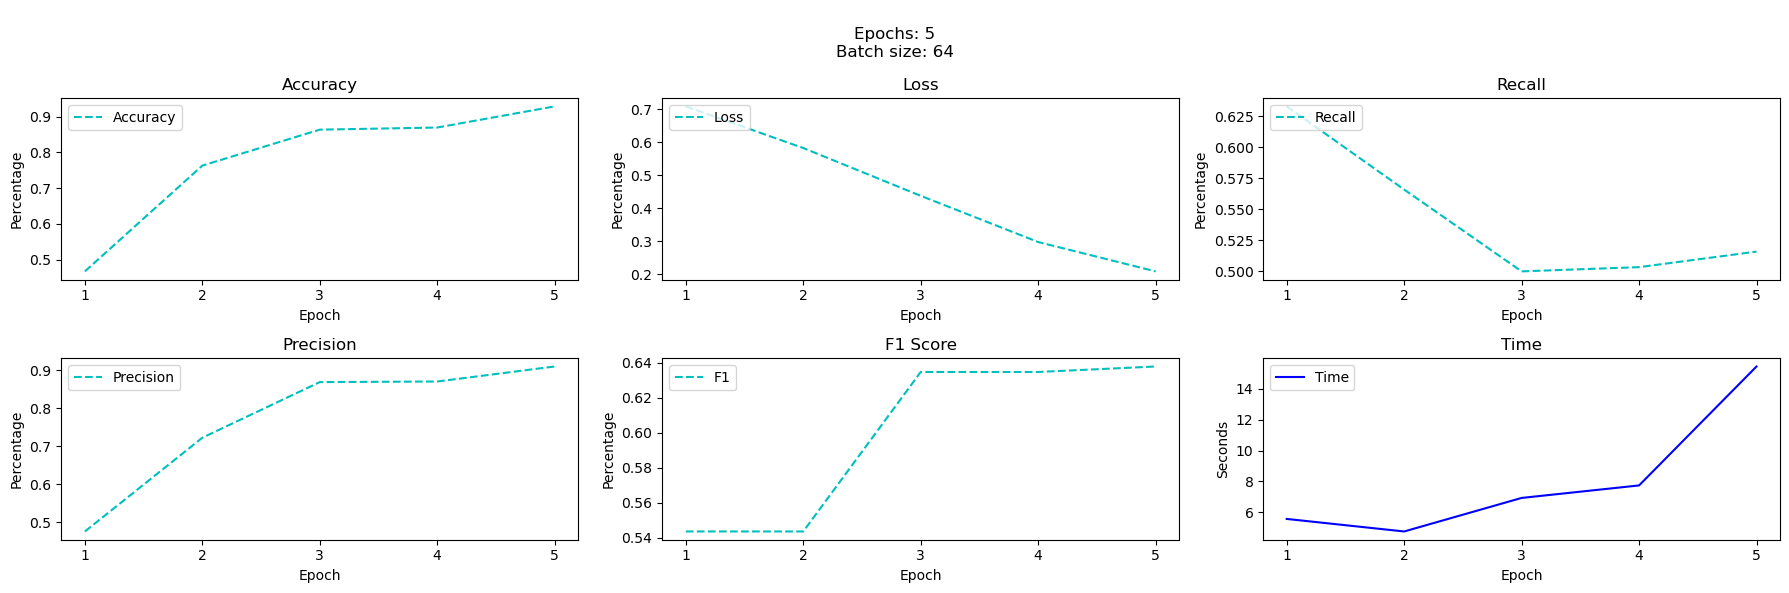

Predicting and scoring...
{'tpos': 8, 'fpos': 0, 'tneg': 10, 'fneg': 1}
Prediction complete. Time cost: 0.879 s.
F1 Score: 0.941
{'batch_size': 64, 'embedding_dim': 128, 'epochs': 5, 'lr': 0.001, 'metric': 'F1', 'vocab_size': 417}
Fitting model...
{'tpos': 35, 'fpos': 36, 'tneg': 48, 'fneg': 50}
[Epoch:   1/  5]
{'tpos': 79, 'fpos': 41, 'tneg': 43, 'fneg': 6}
[Epoch:   2/  5]
{'tpos': 75, 'fpos': 16, 'tneg': 68, 'fneg': 10}
[Epoch:   3/  5]
{'tpos': 73, 'fpos': 10, 'tneg': 74, 'fneg': 12}
[Epoch:   4/  5]
{'tpos': 78, 'fpos': 8, 'tneg': 76, 'fneg': 7}
[Epoch:   5/  5]
Model training complete. Time cost: 41.562 s.


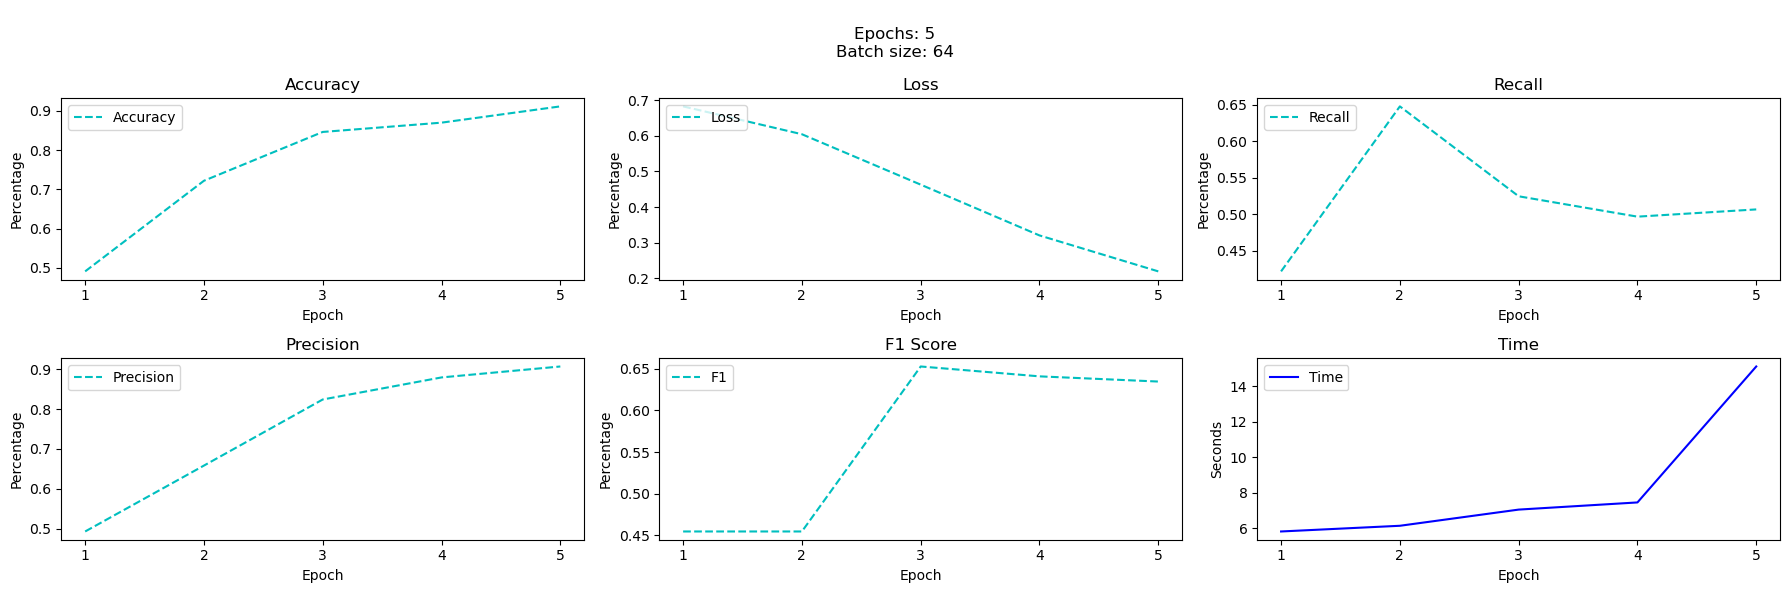

Predicting and scoring...
{'tpos': 9, 'fpos': 1, 'tneg': 9, 'fneg': 0}
Prediction complete. Time cost: 0.788 s.
F1 Score: 0.947
{'batch_size': 64, 'embedding_dim': 128, 'epochs': 5, 'lr': 0.001, 'metric': 'F1', 'vocab_size': 417}
Fitting model...
{'tpos': 57, 'fpos': 56, 'tneg': 28, 'fneg': 28}
[Epoch:   1/  5]
{'tpos': 78, 'fpos': 12, 'tneg': 72, 'fneg': 7}
[Epoch:   2/  5]
{'tpos': 74, 'fpos': 16, 'tneg': 68, 'fneg': 11}
[Epoch:   3/  5]
{'tpos': 71, 'fpos': 12, 'tneg': 72, 'fneg': 14}
[Epoch:   4/  5]
{'tpos': 76, 'fpos': 7, 'tneg': 77, 'fneg': 9}
[Epoch:   5/  5]
Model training complete. Time cost: 41.364 s.


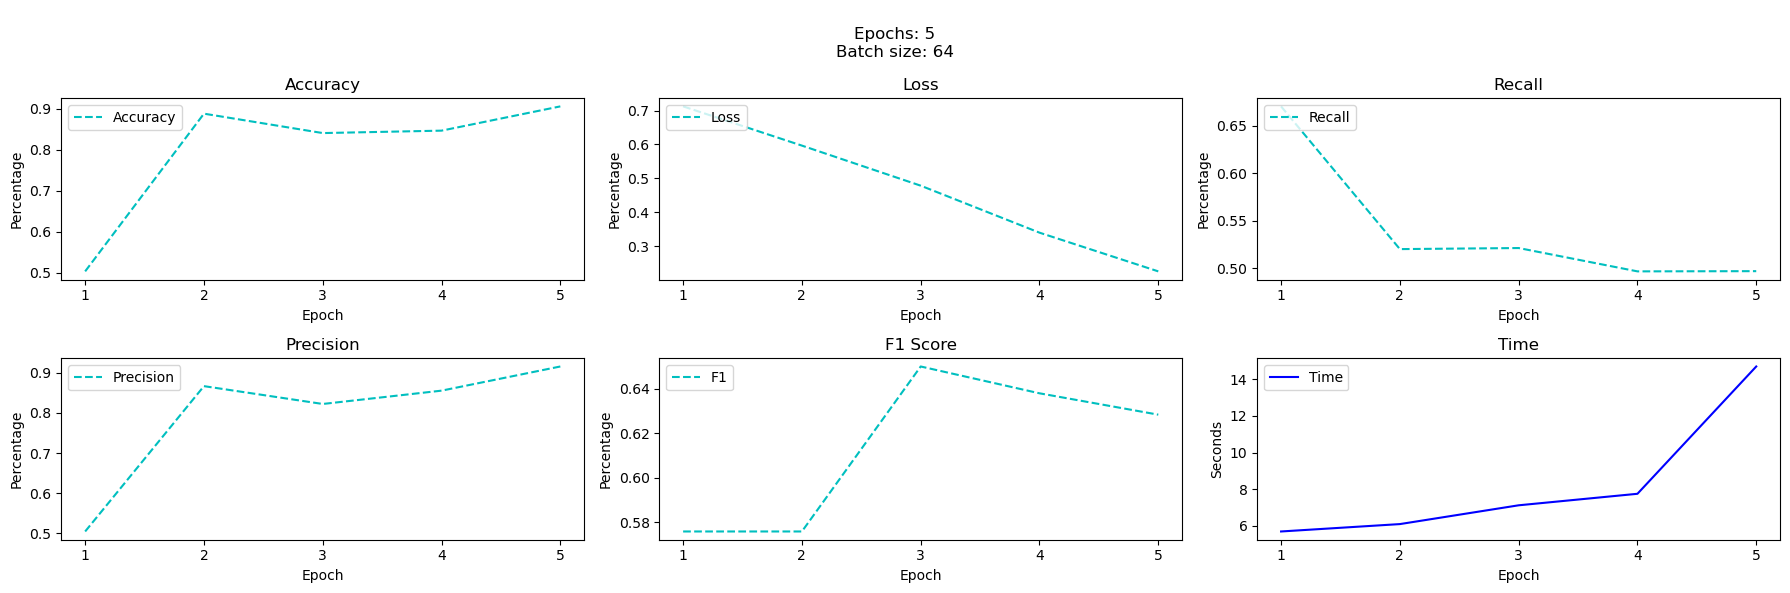

Predicting and scoring...
{'tpos': 9, 'fpos': 0, 'tneg': 10, 'fneg': 0}
Prediction complete. Time cost: 0.854 s.
F1 Score: 1.000
{'batch_size': 64, 'embedding_dim': 128, 'epochs': 5, 'lr': 0.001, 'metric': 'F1', 'vocab_size': 417}
Fitting model...
{'tpos': 73, 'fpos': 41, 'tneg': 43, 'fneg': 12}
[Epoch:   1/  5]
{'tpos': 73, 'fpos': 12, 'tneg': 72, 'fneg': 12}
[Epoch:   2/  5]
{'tpos': 71, 'fpos': 10, 'tneg': 74, 'fneg': 14}
[Epoch:   3/  5]
{'tpos': 72, 'fpos': 8, 'tneg': 76, 'fneg': 13}
[Epoch:   4/  5]
{'tpos': 78, 'fpos': 10, 'tneg': 74, 'fneg': 7}
[Epoch:   5/  5]
Model training complete. Time cost: 41.736 s.


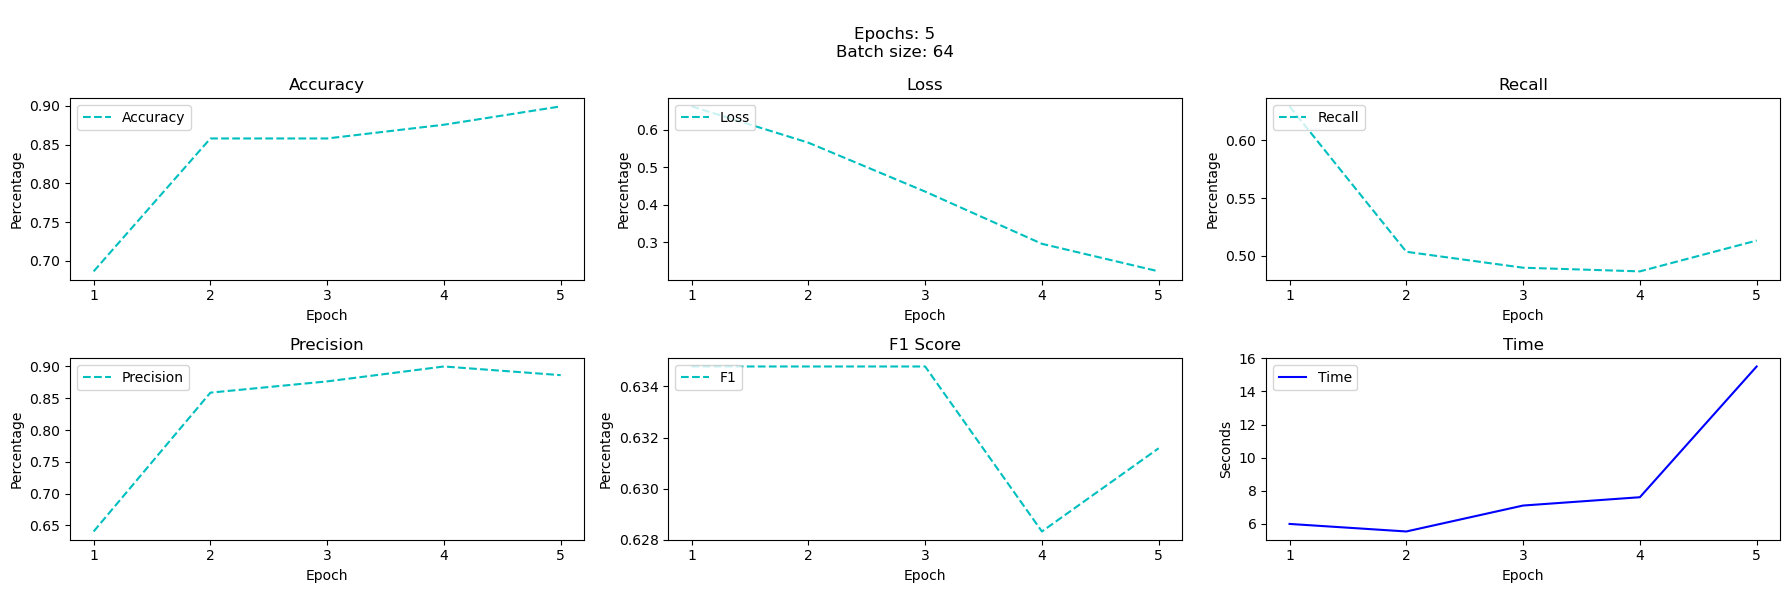

Predicting and scoring...
{'tpos': 7, 'fpos': 1, 'tneg': 9, 'fneg': 2}
Prediction complete. Time cost: 0.625 s.
F1 Score: 0.824
{'batch_size': 64, 'embedding_dim': 128, 'epochs': 5, 'lr': 0.001, 'metric': 'F1', 'vocab_size': 417}
Fitting model...
{'tpos': 51, 'fpos': 54, 'tneg': 31, 'fneg': 33}
[Epoch:   1/  5]
{'tpos': 75, 'fpos': 25, 'tneg': 60, 'fneg': 9}
[Epoch:   2/  5]
{'tpos': 76, 'fpos': 12, 'tneg': 73, 'fneg': 8}
[Epoch:   3/  5]
{'tpos': 75, 'fpos': 3, 'tneg': 82, 'fneg': 9}
[Epoch:   4/  5]
{'tpos': 77, 'fpos': 7, 'tneg': 78, 'fneg': 7}
[Epoch:   5/  5]
Model training complete. Time cost: 40.102 s.


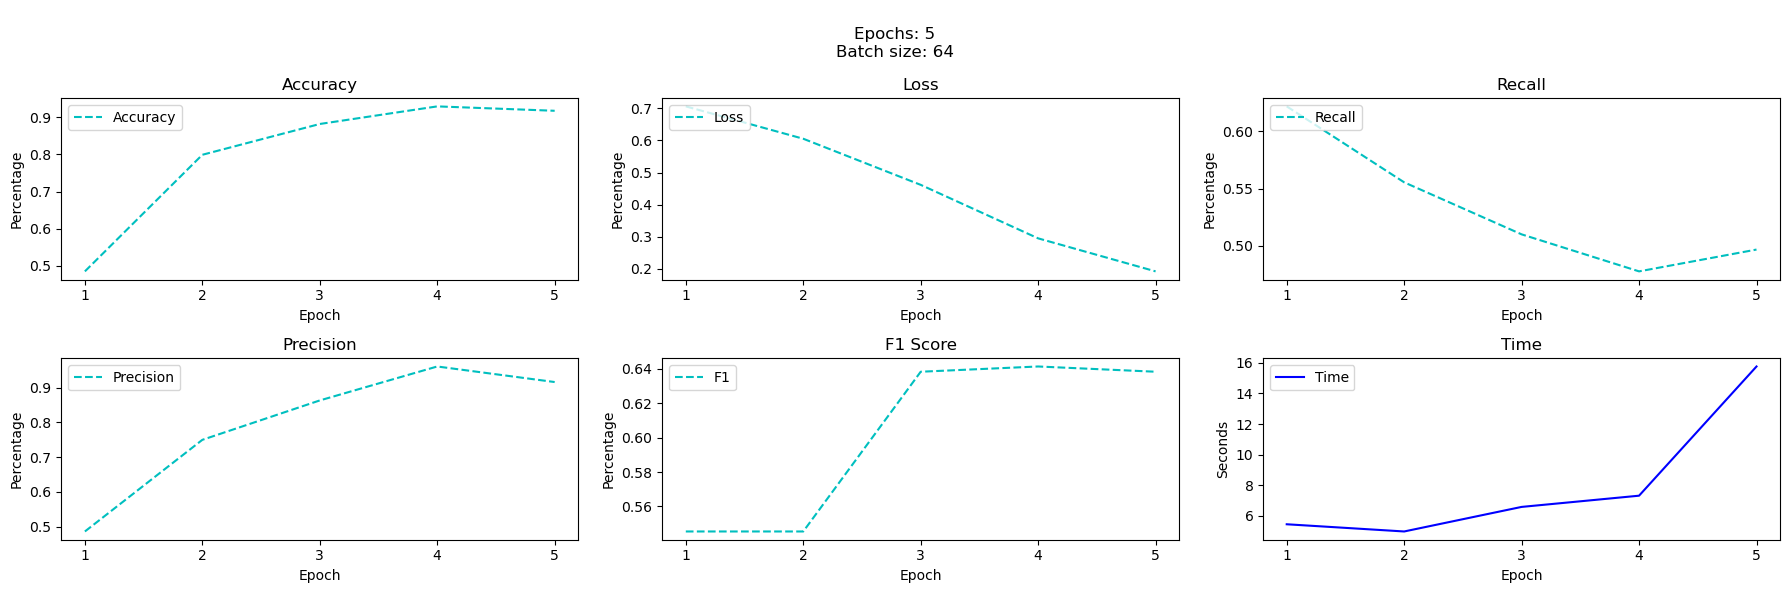

Predicting and scoring...
{'tpos': 6, 'fpos': 1, 'tneg': 8, 'fneg': 4}
Prediction complete. Time cost: 0.573 s.
F1 Score: 0.706
{'batch_size': 64, 'embedding_dim': 128, 'epochs': 5, 'lr': 0.001, 'metric': 'F1', 'vocab_size': 417}
Fitting model...
{'tpos': 33, 'fpos': 31, 'tneg': 54, 'fneg': 51}
[Epoch:   1/  5]
{'tpos': 84, 'fpos': 42, 'tneg': 43, 'fneg': 0}
[Epoch:   2/  5]
{'tpos': 76, 'fpos': 13, 'tneg': 72, 'fneg': 8}
[Epoch:   3/  5]


In [ ]:
# Use skikit-learn's GridSearchCV to find optimal parameter set

import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

root = 'data/'
train_data_ = pd.read_pickle(root+'train/blocks.pkl')
test_data_ = pd.read_pickle(root+'test/blocks.pkl')
train_data_.reset_index(inplace=True, drop=True)

train_data, train_labels = [], []
for _, item in train_data_.iterrows():
    train_data.append(item[1])
    train_labels.append(item[2]-1)
train_labels = torch.LongTensor(train_labels)

test_data, test_labels = [], []
for _, item in test_data_.iterrows():
    test_data.append(item[1])
    test_labels.append(item[2]-1)
test_labels = torch.LongTensor(test_labels)

train_labels, test_labels = train_labels.cpu(), test_labels.cpu()

word2vec = Word2Vec.load(root+"train/embedding/node_w2v_128").wv
embeddings = np.zeros((word2vec.vectors.shape[0] + 1, word2vec.vectors.shape[1]), dtype="float32")
embeddings[:word2vec.vectors.shape[0]] = word2vec.vectors

# Dict of parameters you want to test
params = {
    'embedding_dim': [word2vec.vectors.shape[1]],
    'vocab_size': [word2vec.vectors.shape[0]],
    'metric': ['F1'],
    'batch_size': [64, 32, 16, 8, 4, 2, 1],
    'epochs': [5, 10, 20, 50],
    'lr' : [.001, .01, .1]
}
if gridsearch: 
    print("Using gridsearch")
    # Create GridSearchCV object; model needs embedding_dim and vocab_size declared for initial __init__() call
    astnn = GridSearchCV(BatchProgramClassifier(embedding_dim = word2vec.vectors.shape[1], vocab_size = word2vec.vectors.shape[0]), param_grid=params, cv=10, verbose=1)
else:
    print("Using randomsearch")
    # Create RandomSearchCV object
    astnn = RandomizedSearchCV(BatchProgramClassifier(embedding_dim = word2vec.vectors.shape[1], vocab_size = word2vec.vectors.shape[0]), param_distributions=params, cv=10, verbose=1)
astnn.fit(train_data, train_labels)
print('Best score: ', astnn.best_score_)
print('Best hyperparameters: ', astnn.best_params_)
df = pd.DataFrame.from_dict(astnn.cv_results_)
df.to_csv(path_or_buf='output')

/usr/lib/python3/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
/usr/lib/python3/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
/usr/lib/python3/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
/usr/lib/python3/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).


Fitting model...
{'tpos': 119, 'fpos': 17, 'tneg': 120, 'fneg': 20}
[Epoch:   1/  5]
{'tpos': 130, 'fpos': 2, 'tneg': 135, 'fneg': 9}
[Epoch:   2/  5]
{'tpos': 131, 'fpos': 3, 'tneg': 134, 'fneg': 8}
[Epoch:   3/  5]
{'tpos': 131, 'fpos': 2, 'tneg': 135, 'fneg': 8}
[Epoch:   4/  5]
{'tpos': 132, 'fpos': 2, 'tneg': 135, 'fneg': 7}
[Epoch:   5/  5]
Model training complete. Time cost: 26.326 s.


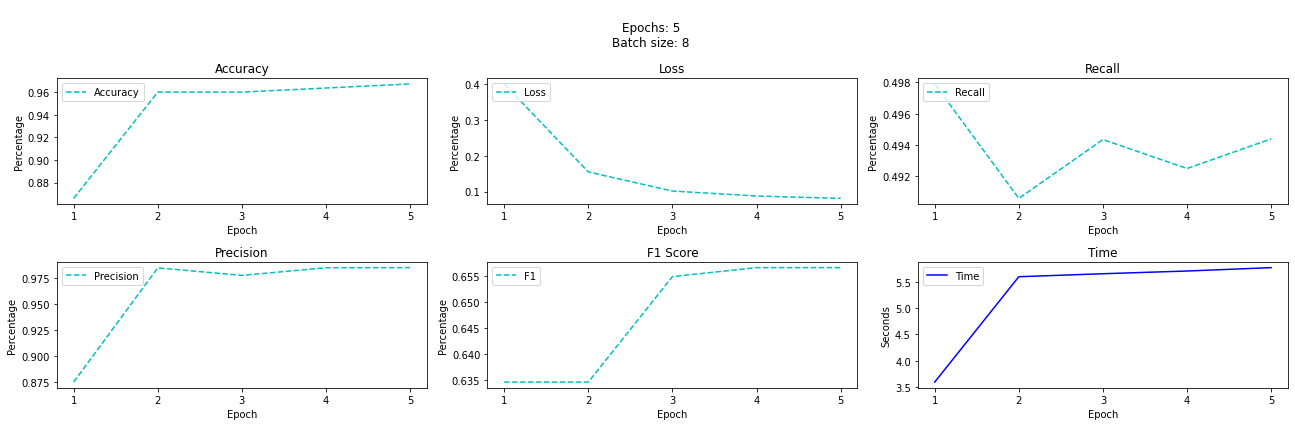

Predicting and scoring...
{'tpos': 29, 'fpos': 0, 'tneg': 36, 'fneg': 5}
Prediction complete. Time cost: 0.998 s.
F1 Score: 0.921


0.9206349206349206

In [4]:
# Create, fit, and score a single model without cross-validation
# Mainly for testing changes to estimator without needing to use GridSearchCV

import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import GridSearchCV

root = 'data/'
train_data_ = pd.read_pickle(root+'train/blocks.pkl')
test_data_ = pd.read_pickle(root+'test/blocks.pkl')
train_data_.reset_index(inplace=True, drop=True)

train_data, train_labels = [], []
for _, item in train_data_.iterrows():
    train_data.append(item[1])
    train_labels.append(item[2]-1)
train_labels = torch.LongTensor(train_labels)

test_data, test_labels = [], []
for _, item in test_data_.iterrows():
    test_data.append(item[1])
    test_labels.append(item[2]-1)
test_labels = torch.LongTensor(test_labels)

train_labels, test_labels = train_labels.cpu(), test_labels.cpu()

word2vec = Word2Vec.load(root+"train/embedding/node_w2v_128").wv
embeddings = np.zeros((word2vec.vectors.shape[0] + 1, word2vec.vectors.shape[1]), dtype="float32")
embeddings[:word2vec.vectors.shape[0]] = word2vec.vectors

model = BatchProgramClassifier(embedding_dim=word2vec.vectors.shape[1], 
                               vocab_size=word2vec.vectorssyn0.shape[0], 
                               batch_size=8, epochs=5, metric='F1')
model.fit(train_data, train_labels)
model.score(test_data, test_labels)

In [ ]:
from sklearn.utils.estimator_checks import check_estimator
model = BatchProgramClassifier(batch_size=32, embedding_dim=128, epochs=15, vocab_size=417)
print(model.label_size)
check_estimator(model)